In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ex. 8

In [10]:
X = np.random.normal(size=100)
eps = np.random.normal(size=100)
y = 3 + 5 * X - 4 * X ** 2 + X ** 3 + eps

In [17]:
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm

def test_k(X, y, k):
    models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
    return k, max(models, key=lambda model: model[1])[0]

def best_subset_selection(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        
        futures = [executor.submit(test_k, X, y, k) for k in range(1, p + 1)]
        for future in as_completed(futures):
            best_of_k[future.result()[0]] = future.result()[1]
            if verbose:
                print(future.result()[0], future.result()[1])
        
    return best_of_k

In [26]:
def forward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    for k in range(1, p + 1):
        names_candidates = [best_of_k[k - 1] + [name] for name in X.columns if name not in best_of_k[k - 1]]
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in names_candidates]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [27]:
def backward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[p] = X.columns.tolist()
    best_of_k[0] = []

    for k in range(p - 1, 0, -1):
        models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(best_of_k[k+1], k)]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [21]:
def evaluate(best_of_k, X, y):
    metrics = pd.DataFrame(columns=['RSS', 'R_squared_adj', 'AIC', 'BIC'])

    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(y, np.ones(y.shape)).fit()
        else:
            model = sm.OLS(y, sm.add_constant(X[list(names)])).fit()
        metrics.loc[k] = [model.ssr, model.rsquared_adj, model.aic, model.bic]
    metrics.sort_index(inplace=True)

    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, col in enumerate(metrics.columns):
        sns.pointplot(metrics.index, metrics[col], marker='o', ax=axes[i%2, i//2], label=col,)
        best = metrics[col].argmax() if col == 'R_squared_adj' else metrics[col].argmin()
        axes[i%2, i//2].set_title(f'Best: {best}')
        sns.scatterplot([best], [metrics[col][best]], marker='o', s=200, color='m', ax=axes[i%2, i//2])

In [33]:
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

In [34]:
%%time
best_models = best_subset_selection(data, y)

1 ('X^1',)
2 ('X^1', 'X^2')
3 ('X^1', 'X^2', 'X^3')
5 ('X^1', 'X^2', 'X^3', 'X^6', 'X^8')
4 ('X^1', 'X^2', 'X^3', 'X^9')
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
7 ('X^1', 'X^2', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10')
8 ('X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10')
6 ('X^1', 'X^2', 'X^3', 'X^6', 'X^8', 'X^10')
CPU times: user 10.3 ms, sys: 47.5 ms, total: 57.8 ms
Wall time: 2.21 s


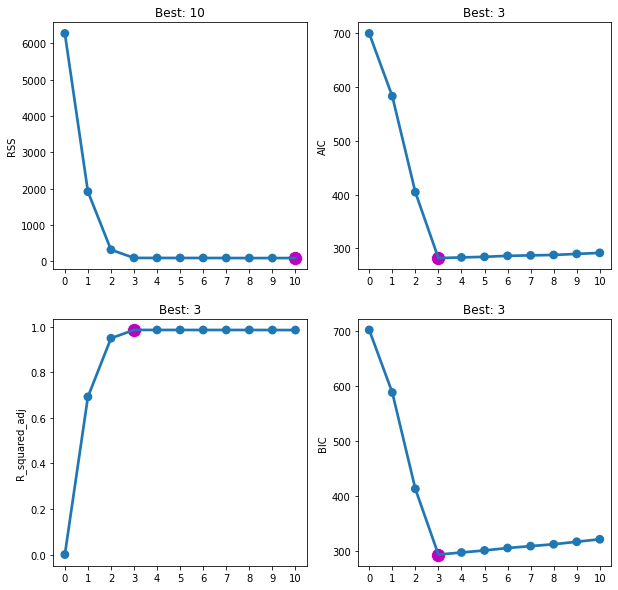

In [35]:
evaluate(best_models, data, y)

All scores show that model with 3 predictors is the best one.

In [36]:
model = sm.OLS(y, sm.add_constant(data[['X^1', 'X^2', 'X^3']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2175.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           4.34e-88
Time:                        23:37:41   Log-Likelihood:                -137.11
No. Observations:                 100   AIC:                             282.2
Df Residuals:                      96   BIC:                             292.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8820      0.127     22.727      0.000       2.630       3.134
X^1            4.9094      0.188     26.093      0.000       4.536       5.283
X^2           -3.8966      0.090    -43.422      0.000      -4.075      -3.718
X^3            0.9964      0.065     15.403      0.000       0.868       1.125
==============================================================================
Omnibus:                        1.615   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.410
Skew:                          -0.291   Prob(JB):                        0.494
Kurtosis:                       2.976   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All coefficient are good estimations of real ones.

1 ['X^1']
2 ['X^1', 'X^2']
3 ['X^1', 'X^2', 'X^3']
4 ['X^1', 'X^2', 'X^3', 'X^9']
5 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4']
6 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4', 'X^8']
7 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4', 'X^8', 'X^5']
8 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4', 'X^8', 'X^5', 'X^6']
9 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4', 'X^8', 'X^5', 'X^6', 'X^7']
10 ['X^1', 'X^2', 'X^3', 'X^9', 'X^4', 'X^8', 'X^5', 'X^6', 'X^7', 'X^10']
CPU times: user 669 ms, sys: 9.35 ms, total: 679 ms
Wall time: 677 ms


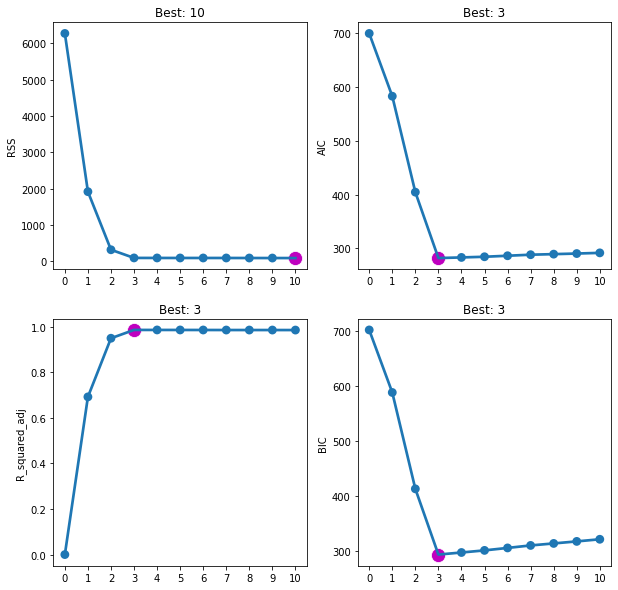

In [37]:
%%time
best_models = forward_stepwise_selection(data, y)
evaluate(best_models, data, y)

9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10')
8 ('X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10')
7 ('X^1', 'X^2', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10')
6 ('X^1', 'X^2', 'X^5', 'X^6', 'X^7', 'X^9')
5 ('X^1', 'X^2', 'X^5', 'X^7', 'X^9')
4 ('X^1', 'X^2', 'X^5', 'X^7')
3 ('X^1', 'X^2', 'X^5')
2 ('X^1', 'X^2')
1 ('X^1',)
CPU times: user 831 ms, sys: 14 ms, total: 845 ms
Wall time: 847 ms


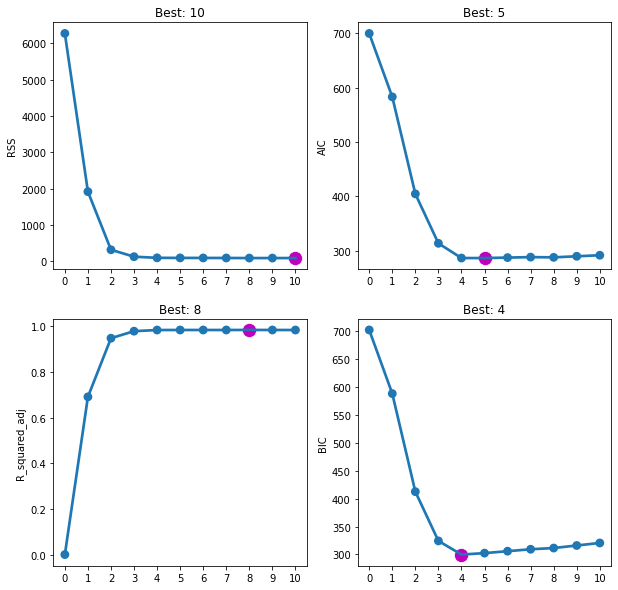

In [38]:
%%time
best_models = backward_stepwise_selection(data, y)
evaluate(best_models, data, y)

Results for forward stepwise selection is the same as with best subset selection. Backward stepwise selection has worse results. It had removed the third predictor almost at start.

In [39]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse

In [47]:
data = data / data.std()

In [56]:
lambdas = np.logspace(-3, 1, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l, normalize=False, max_iter=2000).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

0.018


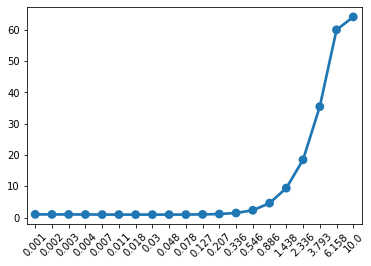

In [57]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [58]:
best_model = Lasso(alpha=best, normalize=False).fit(data, y)
best_model.coef_

array([ 4.80601053, -4.85439162,  3.11968649, -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.07920597])

The coeficients show that lasso was able to cut almost all unrelated variables. But also remaining coeficients differ a little from original ones.

In [59]:
X = np.random.normal(size=100)
eps = np.random.normal(size=100)
y = 8 + 12 * X ** 7 + eps
data = pd.DataFrame()
for i in range(1, 11):
    data[f'X^{i}'] = X ** i
y = pd.Series(y)

1 ('X^7',)
2 ('X^7', 'X^9')
3 ('X^7', 'X^8', 'X^10')
7 ('X^2', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
4 ('X^2', 'X^6', 'X^7', 'X^8')
9 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10')
10 ('X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
5 ('X^4', 'X^6', 'X^7', 'X^8', 'X^10')
6 ('X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10')
8 ('X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10')
CPU times: user 381 ms, sys: 40.3 ms, total: 421 ms
Wall time: 2.65 s


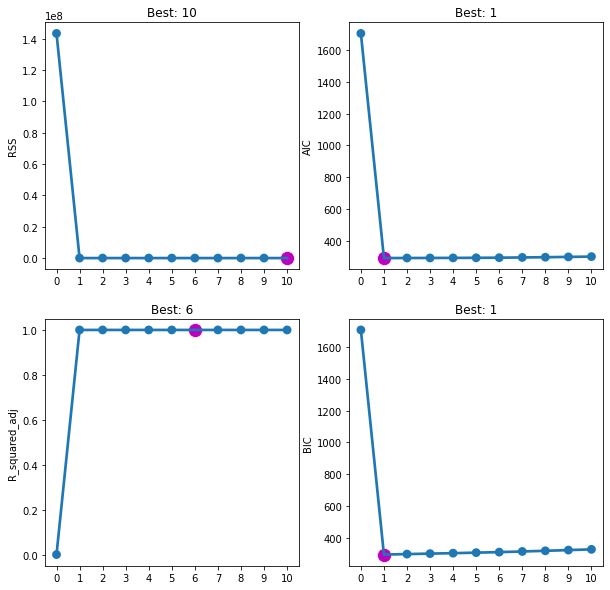

In [60]:
%%time
best_models = best_subset_selection(data, y)
evaluate(best_models, data, y)

In [61]:
model = sm.OLS(y, sm.add_constant(data[['X^7']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.351e+08
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          1.16e-302
Time:                        23:58:08   Log-Likelihood:                -143.84
No. Observations:                 100   AIC:                             291.7
Df Residuals:                      98   BIC:                             296.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8150      0.103     75.866      0.000       7.611       8.019
X^7           11.9999      0.001   1.16e+04      0.000      11.998      12.002
==============================================================================
Omnibus:                        0.310   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.856   Jarque-Bera (JB):                0.115
Skew:                           0.078   Prob(JB):                        0.944
Kurtosis:                       3.055   Cond. No.                         99.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results are as expected.

1.438


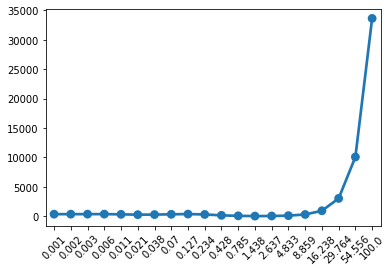

In [65]:
data = data / data.std()
lambdas = np.logspace(-3, 2, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=10)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(data):
        model = Lasso(alpha=l, normalize=False, max_iter=2000).fit(data.iloc[train], y.iloc[train])
        lambda_res.append(mse(y.iloc[test], model.predict(data.iloc[test])))
    res.loc[l] = np.mean(lambda_res)
    
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.index[res.argmin()]
print(best)

In [66]:
best_model = Lasso(alpha=best, normalize=False).fit(data, y)
best_model.coef_

array([ -2.59212487,   0.        ,   0.        ,   0.        ,
       160.75421253,   0.        , 810.08277186,   0.        ,
       237.24410243,   2.42052396])

Lasso had left too much unnecessary variables.